In [11]:
import torch
import math
import numpy as np
import gpytorch
import torch.nn as nn
from gpytorch.kernels import RBFKernel, ScaleKernel
import matplotlib.pyplot as plt

ImportError: cannot import name 'WhiteNoiseKernel' from 'gpytorch.kernels' (c:\users\tllok.n\pycharmprojects\gptour\venv\lib\site-packages\gpytorch\kernels\__init__.py)

In [2]:
XTest = np.loadtxt('./dataset/x_test_high.txt').reshape(-1,32)
XTest = XTest.mean(axis=1).reshape(-1)
YTest = np.loadtxt('./dataset/y_test_high.txt').reshape(-1)

XLow = np.loadtxt('./dataset/x_train_low.txt').reshape(-1,32)
XLow = XLow.mean(axis=1).reshape(-1)
XHigh = np.loadtxt('./dataset/x_train_high.txt').reshape(-1,32)
XHigh = XHigh.mean(axis=1).reshape(-1)
YLow = (np.loadtxt('./dataset/y_train_low.txt')*1e4).reshape(-1)
YHigh = np.loadtxt('./dataset/y_train_high.txt').reshape(-1)

XLow = torch.from_numpy(XLow).float()
YLow = torch.from_numpy(YLow).float()
XHigh = torch.from_numpy(XHigh).float()
YHigh = torch.from_numpy(YHigh).float()
XTest = torch.from_numpy(XTest).float()
YTest = torch.from_numpy(YTest).float()
print(YTest)

tensor([31.1779, 29.1824, 26.4095, 26.9644, 30.0900, 26.8370, 25.2800, 31.4606,
        30.1555])


In [15]:
InDim=32
HidDim=50
OutDim=5

In [16]:
class DeepMultiGPModel(gpytorch.models.ExactGP):
    def __init__(self, InDim,HidDim,OutDim,XLow, YLow, XHigh,YHigh,likelihoodLow,likelihoodHigh):
        super(DeepMultiGPModel, self).__init__(self, InDim,HidDim,OutDim,XLow, YLow, XHigh,YHigh,likelihoodLow,likelihoodHigh)
        self.mean_module_Low = gpytorch.means.ConstantMean()
        self.covar_module_Low = gpytorch.kernels.ScaleKernel(RBFKernel())
        
        self.mean_module_High = gpytorch.means.ConstantMean()
        self.covar_module_High = gpytorch.kernels.ScaleKernel(RBFKernel())
        
        self.Linear1=nn.Linear(InDim,HidDim)
        self.Linear2=nn.Linear(HidDim,OutDim)
        self.ReLu=nn.ReLU()
        

    def forward(self,XLow, YLow, XHigh,YHigh):
        Hidden1=self.Linear1(XLow)
        ReLu1=self.ReLu(Hidden1)
        Output1=self.Linear2(ReLu1)
        Hidden2=self.Linear1(XHigh)
        ReLu2=self.ReLu(Hidden2)
        Output2=self.Linear2(ReLu2)
        
        mean_XLow = self.mean_module_Low(Output1)
        covar_XLow = self.covar_module_Low(OutPut1)
        Distri1=gpytorch.distributions.MultivariateNormal(mean_XLow, covar_XLow)
        XHighNew = torch.stack([Output2, Distri1.mean])
        mean_XHigh = self.mean_module_High(XHighNew)
        covar_XHigh = self.covar_module_High(XHighNew)
        Distri2=gpytorch.distributions.MultivariateNormal(mean_XHigh, covar_XHigh)
        
        return Distri2

In [19]:
likelihoodLow = gpytorch.likelihoods.GaussianLikelihood()
likelihoodHigh= gpytorch.likelihoods.noise_models
model = DeepMultiGPModel(InDim,HidDim,OutDim,XLow, YLow, XHigh,YHigh,likelihoodLow,likelihoodHigh)

TypeError: __init__() takes 4 positional arguments but 11 were given

In [5]:
# Find optimal model hyperparameters
modelLow.train()
likelihoodLow.train()

# Use the adam optimizer
optimizerLow = torch.optim.Adam(modelLow.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mllLow = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoodLow, modelLow)

training_iter_low = 10000
for i in range(training_iter_low):
    optimizerLow.zero_grad()
    outputLow = modelLow(XLow)
    lossLow = -mllLow(outputLow, YLow)
    lossLow.backward()
    if i %10==0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter_low, lossLow.item()))
    optimizerLow.step()

Iter 1/10000 - Loss: 11.726
Iter 11/10000 - Loss: 5.863
Iter 21/10000 - Loss: 4.444
Iter 31/10000 - Loss: 3.884
Iter 41/10000 - Loss: 3.588
Iter 51/10000 - Loss: 3.420
Iter 61/10000 - Loss: 3.302
Iter 71/10000 - Loss: 3.222
Iter 81/10000 - Loss: 3.154
Iter 91/10000 - Loss: 3.103
Iter 101/10000 - Loss: 3.053
Iter 111/10000 - Loss: 3.016
Iter 121/10000 - Loss: 2.991
Iter 131/10000 - Loss: 2.962
Iter 141/10000 - Loss: 2.929
Iter 151/10000 - Loss: 2.911
Iter 161/10000 - Loss: 2.898
Iter 171/10000 - Loss: 2.881
Iter 181/10000 - Loss: 2.859
Iter 191/10000 - Loss: 2.844
Iter 201/10000 - Loss: 2.831
Iter 211/10000 - Loss: 2.818
Iter 221/10000 - Loss: 2.806
Iter 231/10000 - Loss: 2.803
Iter 241/10000 - Loss: 2.787
Iter 251/10000 - Loss: 2.778
Iter 261/10000 - Loss: 2.773
Iter 271/10000 - Loss: 2.769
Iter 281/10000 - Loss: 2.758
Iter 291/10000 - Loss: 2.754
Iter 301/10000 - Loss: 2.748
Iter 311/10000 - Loss: 2.741
Iter 321/10000 - Loss: 2.734
Iter 331/10000 - Loss: 2.732
Iter 341/10000 - Loss: 2

Iter 2771/10000 - Loss: 2.630
Iter 2781/10000 - Loss: 2.625
Iter 2791/10000 - Loss: 2.628
Iter 2801/10000 - Loss: 2.625
Iter 2811/10000 - Loss: 2.625
Iter 2821/10000 - Loss: 2.626
Iter 2831/10000 - Loss: 2.629
Iter 2841/10000 - Loss: 2.630
Iter 2851/10000 - Loss: 2.627
Iter 2861/10000 - Loss: 2.628
Iter 2871/10000 - Loss: 2.625
Iter 2881/10000 - Loss: 2.626
Iter 2891/10000 - Loss: 2.626
Iter 2901/10000 - Loss: 2.627
Iter 2911/10000 - Loss: 2.626
Iter 2921/10000 - Loss: 2.627
Iter 2931/10000 - Loss: 2.629
Iter 2941/10000 - Loss: 2.626
Iter 2951/10000 - Loss: 2.626
Iter 2961/10000 - Loss: 2.625
Iter 2971/10000 - Loss: 2.624
Iter 2981/10000 - Loss: 2.624
Iter 2991/10000 - Loss: 2.627
Iter 3001/10000 - Loss: 2.625
Iter 3011/10000 - Loss: 2.626
Iter 3021/10000 - Loss: 2.625
Iter 3031/10000 - Loss: 2.629
Iter 3041/10000 - Loss: 2.628
Iter 3051/10000 - Loss: 2.630
Iter 3061/10000 - Loss: 2.627
Iter 3071/10000 - Loss: 2.630
Iter 3081/10000 - Loss: 2.625
Iter 3091/10000 - Loss: 2.626
Iter 3101/

Iter 5511/10000 - Loss: 2.626
Iter 5521/10000 - Loss: 2.627
Iter 5531/10000 - Loss: 2.623
Iter 5541/10000 - Loss: 2.623
Iter 5551/10000 - Loss: 2.625
Iter 5561/10000 - Loss: 2.626
Iter 5571/10000 - Loss: 2.625
Iter 5581/10000 - Loss: 2.625
Iter 5591/10000 - Loss: 2.623
Iter 5601/10000 - Loss: 2.623
Iter 5611/10000 - Loss: 2.625
Iter 5621/10000 - Loss: 2.625
Iter 5631/10000 - Loss: 2.623
Iter 5641/10000 - Loss: 2.624
Iter 5651/10000 - Loss: 2.623
Iter 5661/10000 - Loss: 2.626
Iter 5671/10000 - Loss: 2.627
Iter 5681/10000 - Loss: 2.626
Iter 5691/10000 - Loss: 2.627
Iter 5701/10000 - Loss: 2.627
Iter 5711/10000 - Loss: 2.624
Iter 5721/10000 - Loss: 2.624
Iter 5731/10000 - Loss: 2.625
Iter 5741/10000 - Loss: 2.626
Iter 5751/10000 - Loss: 2.626
Iter 5761/10000 - Loss: 2.625
Iter 5771/10000 - Loss: 2.627
Iter 5781/10000 - Loss: 2.625
Iter 5791/10000 - Loss: 2.628
Iter 5801/10000 - Loss: 2.625
Iter 5811/10000 - Loss: 2.626
Iter 5821/10000 - Loss: 2.626
Iter 5831/10000 - Loss: 2.626
Iter 5841/

Iter 8251/10000 - Loss: 2.624
Iter 8261/10000 - Loss: 2.623
Iter 8271/10000 - Loss: 2.623
Iter 8281/10000 - Loss: 2.623
Iter 8291/10000 - Loss: 2.622
Iter 8301/10000 - Loss: 2.623
Iter 8311/10000 - Loss: 2.623
Iter 8321/10000 - Loss: 2.624
Iter 8331/10000 - Loss: 2.623
Iter 8341/10000 - Loss: 2.625
Iter 8351/10000 - Loss: 2.623
Iter 8361/10000 - Loss: 2.625
Iter 8371/10000 - Loss: 2.622
Iter 8381/10000 - Loss: 2.623
Iter 8391/10000 - Loss: 2.622
Iter 8401/10000 - Loss: 2.623
Iter 8411/10000 - Loss: 2.623
Iter 8421/10000 - Loss: 2.621
Iter 8431/10000 - Loss: 2.624
Iter 8441/10000 - Loss: 2.623
Iter 8451/10000 - Loss: 2.624
Iter 8461/10000 - Loss: 2.624
Iter 8471/10000 - Loss: 2.624
Iter 8481/10000 - Loss: 2.625
Iter 8491/10000 - Loss: 2.624
Iter 8501/10000 - Loss: 2.623
Iter 8511/10000 - Loss: 2.624
Iter 8521/10000 - Loss: 2.623
Iter 8531/10000 - Loss: 2.624
Iter 8541/10000 - Loss: 2.623
Iter 8551/10000 - Loss: 2.623
Iter 8561/10000 - Loss: 2.623
Iter 8571/10000 - Loss: 2.622
Iter 8581/

In [6]:
modelLow.eval()
likelihoodLow.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihoodLow(modelLow(XHigh))
    print(XHigh.shape)
XHighNew = torch.stack([XHigh, observed_pred.mean]).T
print(observed_pred.mean.numpy())
XHighNew=XHighNew.mean(axis=1)
print(XHighNew)
print(XHigh)

torch.Size([21])
[35.195095 35.881016 36.22503  35.195095 37.123    36.38499  35.150444
 35.150444 35.623177 37.123    36.64236  35.5232   36.891277 37.503212
 35.652092 35.150444 36.737743 36.98079  35.150444 35.195095 35.195095]
tensor([17.6444, 17.8468, 18.2375, 17.6444, 18.3896, 18.0675, 17.5440, 17.5440,
        17.3741, 18.3896, 18.1806, 17.8397, 18.2894, 18.5485, 17.7479, 17.5440,
        18.5251, 18.6623, 17.5440, 17.6444, 17.6444])
tensor([ 0.0938, -0.1875,  0.2500,  0.0938, -0.3438, -0.2500, -0.0625, -0.0625,
        -0.8750, -0.3438, -0.2812,  0.1562, -0.3125, -0.4062, -0.1562, -0.0625,
         0.3125,  0.3438, -0.0625,  0.0938,  0.0938])


In [7]:
likelihoodHigh = gpytorch.likelihoods.GaussianLikelihood()
modelHigh = SpectralMixtureGPModel(XHighNew, YHigh, likelihoodHigh)

In [8]:
# Find optimal model hyperparameters
modelHigh.train()
likelihoodHigh.train()

# Use the adam optimizer
optimizerHigh = torch.optim.Adam(modelHigh.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mllHigh = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoodHigh, modelHigh)

training_iter_high = 10000
for i in range(training_iter_high):
    optimizerHigh.zero_grad()
    outputHigh = modelHigh(XHighNew)
    lossHigh = -mllHigh(outputHigh, YHigh)
    lossHigh.backward()
    if i %10==0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter_high, lossHigh.item()))
    optimizerHigh.step()

Iter 1/10000 - Loss: 60.792
Iter 11/10000 - Loss: 17.958
Iter 21/10000 - Loss: 10.525
Iter 31/10000 - Loss: 8.097
Iter 41/10000 - Loss: 6.983
Iter 51/10000 - Loss: 6.316
Iter 61/10000 - Loss: 5.842
Iter 71/10000 - Loss: 5.469
Iter 81/10000 - Loss: 5.157
Iter 91/10000 - Loss: 4.889
Iter 101/10000 - Loss: 4.655
Iter 111/10000 - Loss: 4.449
Iter 121/10000 - Loss: 4.266
Iter 131/10000 - Loss: 4.101
Iter 141/10000 - Loss: 3.954
Iter 151/10000 - Loss: 3.822
Iter 161/10000 - Loss: 3.705
Iter 171/10000 - Loss: 3.606
Iter 181/10000 - Loss: 3.522
Iter 191/10000 - Loss: 3.450
Iter 201/10000 - Loss: 3.388
Iter 211/10000 - Loss: 3.333
Iter 221/10000 - Loss: 3.284
Iter 231/10000 - Loss: 3.240
Iter 241/10000 - Loss: 3.199
Iter 251/10000 - Loss: 3.163
Iter 261/10000 - Loss: 3.129
Iter 271/10000 - Loss: 3.099
Iter 281/10000 - Loss: 3.070
Iter 291/10000 - Loss: 3.044
Iter 301/10000 - Loss: 3.020
Iter 311/10000 - Loss: 2.997
Iter 321/10000 - Loss: 2.975
Iter 331/10000 - Loss: 2.954
Iter 341/10000 - Loss:

Iter 2781/10000 - Loss: 2.310
Iter 2791/10000 - Loss: 2.310
Iter 2801/10000 - Loss: 2.310
Iter 2811/10000 - Loss: 2.310
Iter 2821/10000 - Loss: 2.310
Iter 2831/10000 - Loss: 2.310
Iter 2841/10000 - Loss: 2.310
Iter 2851/10000 - Loss: 2.310
Iter 2861/10000 - Loss: 2.310
Iter 2871/10000 - Loss: 2.310
Iter 2881/10000 - Loss: 2.310
Iter 2891/10000 - Loss: 2.310
Iter 2901/10000 - Loss: 2.310
Iter 2911/10000 - Loss: 2.310
Iter 2921/10000 - Loss: 2.310
Iter 2931/10000 - Loss: 2.309
Iter 2941/10000 - Loss: 2.309
Iter 2951/10000 - Loss: 2.309
Iter 2961/10000 - Loss: 2.309
Iter 2971/10000 - Loss: 2.309
Iter 2981/10000 - Loss: 2.309
Iter 2991/10000 - Loss: 2.309
Iter 3001/10000 - Loss: 2.309
Iter 3011/10000 - Loss: 2.309
Iter 3021/10000 - Loss: 2.309
Iter 3031/10000 - Loss: 2.309
Iter 3041/10000 - Loss: 2.309
Iter 3051/10000 - Loss: 2.309
Iter 3061/10000 - Loss: 2.309
Iter 3071/10000 - Loss: 2.309
Iter 3081/10000 - Loss: 2.309
Iter 3091/10000 - Loss: 2.309
Iter 3101/10000 - Loss: 2.309
Iter 3111/

Iter 5521/10000 - Loss: 2.139
Iter 5531/10000 - Loss: 2.139
Iter 5541/10000 - Loss: 2.139
Iter 5551/10000 - Loss: 2.139
Iter 5561/10000 - Loss: 2.139
Iter 5571/10000 - Loss: 2.139
Iter 5581/10000 - Loss: 2.138
Iter 5591/10000 - Loss: 2.138
Iter 5601/10000 - Loss: 2.138
Iter 5611/10000 - Loss: 2.138
Iter 5621/10000 - Loss: 2.138
Iter 5631/10000 - Loss: 2.138
Iter 5641/10000 - Loss: 2.138
Iter 5651/10000 - Loss: 2.138
Iter 5661/10000 - Loss: 2.138
Iter 5671/10000 - Loss: 2.138
Iter 5681/10000 - Loss: 2.137
Iter 5691/10000 - Loss: 2.137
Iter 5701/10000 - Loss: 2.137
Iter 5711/10000 - Loss: 2.137
Iter 5721/10000 - Loss: 2.137
Iter 5731/10000 - Loss: 2.137
Iter 5741/10000 - Loss: 2.137
Iter 5751/10000 - Loss: 2.137
Iter 5761/10000 - Loss: 2.137
Iter 5771/10000 - Loss: 2.137
Iter 5781/10000 - Loss: 2.137
Iter 5791/10000 - Loss: 2.137
Iter 5801/10000 - Loss: 2.137
Iter 5811/10000 - Loss: 2.137
Iter 5821/10000 - Loss: 2.136
Iter 5831/10000 - Loss: 2.136
Iter 5841/10000 - Loss: 2.136
Iter 5851/

Iter 8331/10000 - Loss: 2.134
Iter 8341/10000 - Loss: 2.134
Iter 8351/10000 - Loss: 2.134
Iter 8361/10000 - Loss: 2.134
Iter 8371/10000 - Loss: 2.134
Iter 8381/10000 - Loss: 2.134
Iter 8391/10000 - Loss: 2.134
Iter 8401/10000 - Loss: 2.134
Iter 8411/10000 - Loss: 2.134
Iter 8421/10000 - Loss: 2.134
Iter 8431/10000 - Loss: 2.134
Iter 8441/10000 - Loss: 2.134
Iter 8451/10000 - Loss: 2.134
Iter 8461/10000 - Loss: 2.134
Iter 8471/10000 - Loss: 2.134
Iter 8481/10000 - Loss: 2.134
Iter 8491/10000 - Loss: 2.134
Iter 8501/10000 - Loss: 2.134
Iter 8511/10000 - Loss: 2.134
Iter 8521/10000 - Loss: 2.134
Iter 8531/10000 - Loss: 2.134
Iter 8541/10000 - Loss: 2.134
Iter 8551/10000 - Loss: 2.134
Iter 8561/10000 - Loss: 2.134
Iter 8571/10000 - Loss: 2.134
Iter 8581/10000 - Loss: 2.134
Iter 8591/10000 - Loss: 2.134
Iter 8601/10000 - Loss: 2.134
Iter 8611/10000 - Loss: 2.134
Iter 8621/10000 - Loss: 2.134
Iter 8631/10000 - Loss: 2.134
Iter 8641/10000 - Loss: 2.134
Iter 8651/10000 - Loss: 2.134
Iter 8661/

In [9]:
# Get into evaluation (predictive posterior) mode
modelHigh.eval()
likelihoodHigh.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
nsamples=1000
Nts=9
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_pred1 = likelihoodLow(modelLow(XTest))
    mean1=observed_pred1.mean
    var1=observed_pred1.covariance_matrix
    Z = np.random.multivariate_normal(mean1.flatten(),var1,nsamples)
    
    # push samples through f_2
    tmp_m = np.zeros((nsamples,Nts))
    tmp_v = np.zeros((nsamples,Nts))
    XTest=XTest.reshape(-1,1)
    
    for i in range(0,nsamples):
        XTest2=torch.from_numpy(np.vstack((XTest, Z[i,:][:,None]))).float().mean(axis=0).reshape(-1)
        observed_pred2 =likelihoodHigh(modelHigh(XTest2))
        mean2=observed_pred2.mean
        var2=observed_pred2.covariance_matrix
        tmp_m[i,:] = mean2.flatten()
        tmp_v[i,:] = var2.flatten()

    # get posterior mean and variance
    mean = np.mean(tmp_m, axis = 0)[:,None]
    var = np.mean(tmp_v, axis = 0)[:,None]+ np.var(tmp_m, axis = 0)[:,None]
    var = np.abs(var)

    error = np.linalg.norm(YTest - mean)/np.linalg.norm(YTest)
     
    print(mean)
    print(error)

c:\users\tllok.n\pycharmprojects\gptour\venv\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  


[[26.76227698]
 [26.76227698]
 [26.76227698]
 [26.76227698]
 [26.76227698]
 [26.76227698]
 [26.76227698]
 [26.76227698]
 [26.76227698]]
0.2964664282893457


ValueError: x and y must have same first dimension, but have shapes (9, 1) and (1,)

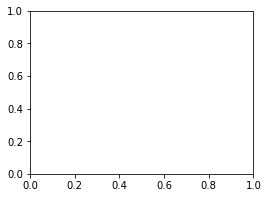

In [10]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))

# Get upper and lower confidence bounds
lower, upper = observed_pred2.confidence_region()
# Plot training data as black stars
# ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
# Plot predictive means as blue line
ax.plot(XTest.numpy(), observed_pred2.mean.numpy(), 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(XTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
ax.set_ylim([-5, 5])
ax.legend(['Mean', 'Confidence'])